## CONTENT RANKING REPORT

In [8]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

Mỗi ngày chúng ta tiếp xúc với rất nhiều nội dung từ dạng chữ, video, hình ảnh,..Từ đó cũng sinh ra nhu cầu phân loại nội dung, hệ thống này giúp cho người tạo nội dung biết mức độ chất lượng của bài viết để cải thiện từ đó tăng độ tương tác và thu hút hơn. Bên cạnh đó người tiếp nhận nội dung cũng có thể phân loại những bài viết giá trị tránh mất thời gian vào những bài viết không mang nhiều nội dung hoặc lọc theo những nội dung cần đọc.

Ví dụ xem qua 2 bài dưới đây để thấy sự khác nhau giữa chất lượng bài viết.
- Bài viết chất lượng cao: https://en.wikipedia.org/wiki/Elizabeth_II
- Bài viết chất lượng thấp: https://en.wikipedia.org/wiki/Ring-tailed_cardinalfish

Dưới đây tôi muốn trình bày về mô hình phân loại về nội dung của mình. Bài viết sẽ đi theo các phần sau:
- ***I. Hiệu quả của mô hình.***
- ***II. Demo một số ví dụ.***
- ***III. Cách sử dụng.***

In [9]:
import sys
sys.path.append('/home/waves8/Thy/Wikipedia-Knowledge-Graph')
import os
os.chdir("/home/waves8/Thy/Wikipedia-Knowledge-Graph")
from IPython.display import Image
from src.utils.preporcess_demo import *
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

### I. Hiệu quả của mô hình.

Project này sử dụng tập dữ liệu Wikipedia với 30000 bài báo được đánh giá của người đọc với thứ tự giảm dần như sau:

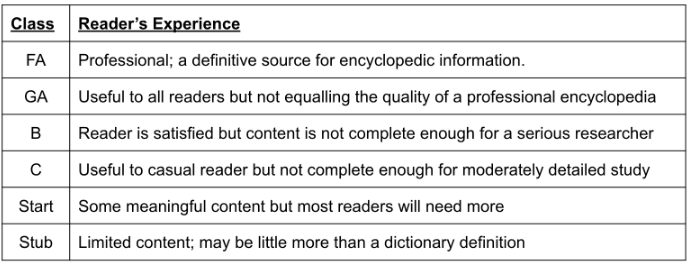

In [3]:
Image("image/class_definition.png")

Cần chú ý rằng, phần đánh giá này mang tính chủ quan và khó để phân biệt rõ ràng giữa 2 lớp. Ví dụ, "FA" thể hiện cho những bài viết mang tính chuyên nghiệp cao, trong khi "GA" cũng "gần như" chuyen nghiệp, 2 khía cạnh không hoàn toàn tách biệt.

Sau khi train, kiểm tra performace với dữ liệu test.Kết quả như sau.

In [6]:
{"fa":0, "c":1,"start":2,"stub":3,"b":4, "ga":5}

{'b': 4, 'c': 1, 'fa': 0, 'ga': 5, 'start': 2, 'stub': 3}

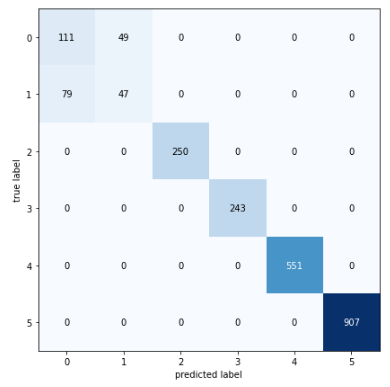

In [7]:
Image("image/performace.png")

Dễ dang nhận thấy mô hình hoạt động khá tốt trên đa số nhóm, tuy nhiên còn nhầm lẫn giữa "FA"-bài viết chuyên nghiệp và "C" bài viết phổ thông, dưới đây sẽ so sánh các feature tạo ra sự nhầm lẫn này.

Khi so sánh những mẫu bị dự đoán sai, ta thấy có sự tác động bởi chiều dài của bài viết, ở nhóm có label bằng 1 có phân bố độ dài khoảng 10000 đến 15000 ký tự, và nhóm bị dữ đoán sai cũng có chiều dài nằm trong đoạn này.

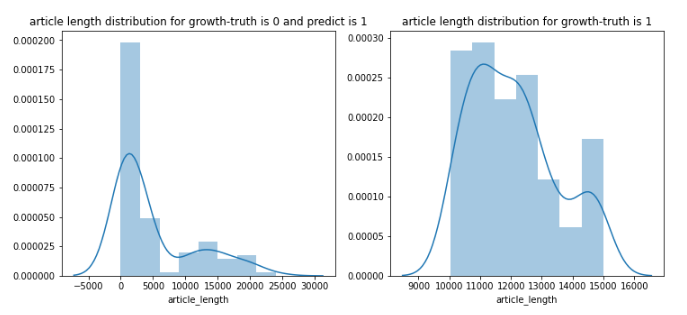

In [11]:
Image("image/misclassifier.png")

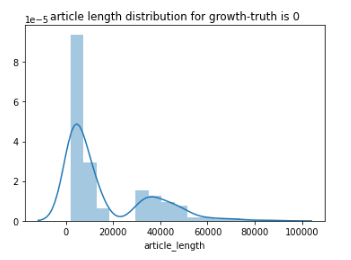

In [12]:
Image("image/label0.png")

Hình dưới đây cho thấy tầm quan trọng của các features với việc tạo ra kết quả, "article_length" là feature quan trọng nhất. Tiếp đến là gunning_fox_index (chỉ số thể hiện cấp lớp có thể hiểu văn bản từ lần đọc đầu tiên, chỉ số càng cao thể hiện văn bản cần nhiều kiến thức để hiểu, https://en.wikipedia.org/wiki/Gunning_fog_index), bên cạnh đó còn có chỉ số âm tiết, số lượng từ khó cũng nằm trong nhóm những feature quan trọng. Như vậy, để một bài viết được đánh giá chất lượng, tác giả cần chú ý đến các yếu tố trên.

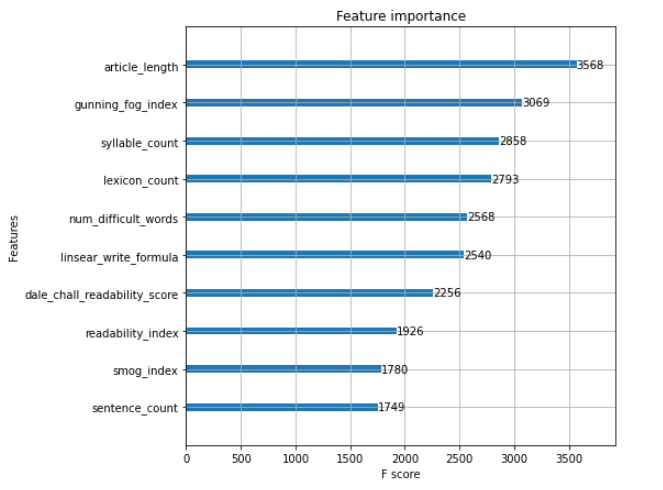

In [4]:
Image("image/feature_importance.png")

### II. Demo một số ví dụ.

Model sẽ nhận input là raw_text, sau đó sẽ transform ra các features numerical khác.Dưới đây trình bày 3 ví dụ khác nhau khi input một đoạn text.

In [10]:
from tensorflow.keras.models import Sequential, load_model, Model
model = load_model('model/model_lsmt')

import keras.preprocessing.text as kpt
from keras.preprocessing import sequence, text
import preprocessor as p
import emoji
from tensorflow.keras.models import load_model
from keras.preprocessing import sequence, text
from tensorflow.keras.preprocessing.text import Tokenizer
def convert_text_to_index_array(text, tokenizer_path):
    with open(tokenizer_path, 'rb') as handle:
        tokenizer = pickle.load(handle)
    words = kpt.text_to_word_sequence(text)
    wordIndices = []
    for word in words:
        if word in tokenizer:
            wordIndices.append(tokenizer[word])
    return wordIndices

def get_ranking(model,tokenizer_path,texts):
    text = clean_text(texts)
    #tokenize
    twt = convert_text_to_index_array(text,tokenizer_path)
    twt = sequence.pad_sequences([twt], maxlen=1000, dtype='int32')
    sentiment = model.predict(twt,batch_size=1,verbose = 2)
    sent = np.round(np.dot(sentiment,100).tolist(),0)[0]
    result = pd.DataFrame([sent_to_id.keys(),sent]).T
    result.columns = ["sentiment","percentage"]
    result=result[result.percentage !=0]
    return result

### Demo 1: Bài báo viết về John Linton Treloar
https://en.wikipedia.org/wiki/John_Treloar_(museum_administrator)

Dưới đây là toàn bộ bài viết về John Linton Treloar, với một bài viết về nhân vật lịch sử, bài viết được đầu tư khá kỹ lưỡng, nên mô hình đánh giá bài viết này ở thang cao nhất.

In [7]:
text = 'John Linton Treloar, OBE (10December 1894  28January 1952) was an Australian archivist and the second director of the Australian War Memorial (AWM). During World War I he served in several staff roles and later headed the First Australian Imperial Forces (AIF) record-keeping unit. From 1920 Treloar played an important role in establishing the AWM as its director. He headed an Australian Government department during the first years of World War II, and spent the remainder of the war in charge of the Australian militarys history section. Treloar returned to the AWM in 1946, and continued as its director until his death.Treloars career was focussed on the Australian military and its history. Prior to World War I he worked as a clerk in the Department of Defence and, after volunteering for the AIF in 1914, formed part of the Australian Army officer Brudenell Whites staff for most of the wars first years. He was appointed commander of the Australian War Records Section (AWRS) in 1917. In this position, he improved the AIFs records and collected a large number of artefacts for later display in Australia. Treloar was appointed the director of what eventually became the AWM in 1920, and was a key figure in establishing the Memorial and raising funds for its permanent building in Canberra. He left the AWM at the outbreak of World War II to lead the Australian Governments Department of Information, but was effectively sidelined for much of 1940. In early 1941 he was appointed to command the Australian militarys Military History and Information Section with similar responsibilities to those he had held during World War I. He attempted to intervene in the management of the AWM during his absence, however, to the increasing frustration of its acting director. Treloar worked intensely in all his roles and suffered periods of ill-health as a result. Following the war, he returned to the Memorial in 1946 but his performance deteriorated over time, possibly due to exhaustion. He died in January 1952. Treloar continues to be regarded as an important figure in Australian military history. His principal achievements are seen as gathering and classifying Australias records of the world wars and successfully establishing the AWM. The street behind the Memorial and its main storage annex were named in Treloars honour following his death.World War IJohn Treloar was born in Melbourne on 10December 1894. His father was a sales representative for Carlton & United Breweries and his mother was a strict Methodist. Treloar was educated at Albert Park State School and became a trained Sunday school teacher. He was not able to attend university, but sought self-education in Melbournes museums and libraries. Treloar also participated in his schools cadet unit, and believed that the military offered a means to follow his ambition for a career in a field other than small business. He was also a capable footballer, cricket player and athlete and was invited to train with the South Melbourne Football Club. He took his fathers advice to wait until he was 21 before playing senior games, however, and instead took a job with the Department of Defence after he left school in 1911. In this position he worked as a clerk for Brudenell White, who was later a leading Australian staff officer of World War I and the commander of the Australian Army during the early months of World War II.Treloar in 1916 shortly before he left Australia for EgyptOn 16August 1914, shortly after the outbreak of World War I, Treloar enlisted in the First Australian Imperial Force (AIF) and became a staff sergeant working for White in the headquarters of the 1stDivision. He landed at Anzac Cove with the rest of the 1stDivisions Headquarters during the morning of 25April 1915, and subsequently participated in the Gallipoli Campaign. Treloars duties were mainly clerical, and included typing reports, orders and dispatches from senior officers. He frequently worked from 7am to midnight, and this took a toll on his health. He contracted typhoid in late August, and was evacuated to Egypt on 4September. Treloar came close to dying from this disease, and was returned to Australia to recuperate. He arrived in Melbourne on 4December 1915. During his convalescence, Treloar resumed a pre-war friendship with Clarissa Aldridge and the couple became engaged.When he recovered his health, Treloar returned to the military. An attempt to rejoin Brudenell Whites staff was unsuccessful, and he instead was posted to the Australian Flying Corps (AFC) with the rank of lieutenant. In February 1916, Treloar was assigned to No. 1 Squadron AFC in Egypt and served as its equipment officer until July 1916, when he was transferred to France to become Whites confidential clerk in the headquarters of I Anzac Corps. At the time of the Battle of Pozires in late July Treloar was in charge of the corps headquarters Central Registry, which was responsible for communications within the headquarters as well as distributing orders to its subordinate units.  During his staff roles Treloar gained a good understanding of military record-keeping. In May 1917, he was selected by White to command the newly established Australian War Records Section (AWRS), and was promoted to the rank of captain. At the time he knew nothing of the Sections role, and was unable to find any information about it.Treloar assumed command of the AWRS on 16May 1917. At this time the Section comprised four enlisted soldiers and occupied two rooms in the British Public Record Offices (PRO) building in London. Established upon the urging of the official Australian war correspondent Charles Bean, the unit was responsible for gathering records to serve as source material for the official histories that were to be written after the war. At this stage Australia did not have a national archive or public records office, and the AWRS was the first organisation set up to preserve any Commonwealth Government records. A comparison of the war diaries completed by the AIF in one month before the AWRS was established (left) and after it commenced work improving them (right)Treloars first challenge was to improve the quality of the war diaries kept by AIF units. These diaries were meant to be maintained by each element of the AIF as a record of its activities for later use by historians, but at the time most units recorded few details. To this end, Treloar met with many of the officers responsible for units war diaries and frequently provided written advice and feedback on the quality of the records submitted to the Section; these methods had previously been used by the Canadian military. Treloar also sought to motivate relevant personnel by demonstrating that the diaries were valued and would be important in ensuring that their unit received recognition for its achievements after the war. In August 1917 the AWRS expanded its activities to include collecting artefacts from the French battlefields. Its tasks increased further in September when it took over responsibility for supervising the official war artists as well as producing and keeping records of non-official publications such as regimental magazines. Individual soldiers were encouraged to contribute artefacts and records, and the AWRS provided museum labels to combat units to encourage them to record the significance and origins of items they submitted. The AWRS established field offices in France and Egypt, and reached a strength of about 600 soldiers and civilians in November 1918. From November 1917 until August 1918 the war correspondent Henry Gullett commanded the AWRS subsection in Cairo; in this role he reported directly to Treloar. As a result of the AWRS expansion, in March 1918 its headquarters moved from the PRO building to a larger office on Horseferry Road opposite the main offices of the AIF Administrative Headquarters. As commander of the AWRS, Treloar worked enthusiastically and at times had to be ordered to take holidays. He told Bean that he was motivated "to do something really worthwhile for Australia" by bringing together the records covering Australias role in the war. He actively pursued records and artefacts covering a wide range of the AIFs activities. While Bean was impressed by Treloars achievements, he believed that the young man was pushing himself too hard and was in danger of a breakdown. Although they shared accommodations for a period, the two men were not close. Treloar was appointed a Member of the Order of the British Empire (MBE) on 3June 1918 for "services in connection with the war" and was promoted to major in December 1918. While this promotion recognised his achievements as commander of the AWRS, it was mainly intended to improve his status when he attended meetings of the War Trophies Commission; the British representative on this commission was a major general. Treloar arranged for Clarissa Aldridge to travel to Britain in 1918, and they were married in London on 5November. The couple eventually had two daughters and two sons.Following the war, Treloar continued to organise the records the AWRS had collected. In the months after the war the Section was assigned a large number of soldiers to assist with this task. The AWRS also continued to gather artefacts, and by February 1919 it had a collection of over 25,000 items; Treloar regarded this as "a good collection" but still not sufficient. He sought to collect records and memorabilia relevant to all aspects of Australias experience in World War I, including material concerning the worst aspects of the Australian military. In doing so, Treloar deliberately did not make judgments on the historical value of the records and items submitted to the AWRS as he believed that this task should be left to others. On 3June 1919 he was appointed an Officer of the Order of the British Empire (OBE), for "valuable services rendered in connexion with the war". Treloar arrived back in Australia on 18July 1919. The large quantity of artefacts and records which the AWRS had gathered were also returned to Australia in 1919, though work on organising them into an archive was not completed until 1932. The Australian War Museum was formed in 1919 on the basis of the Sections collection, and Treloar joined the Museum at some stage during the year. Henry Gullett was appointed the War Museums first director after Bean turned down the position so that he could focus on editing and writing the Official History of Australia in the War of 19141918. Bean, Gullet and Treloar were subsequently the key figures in the establishment of the AWM.Establishing the War MemorialPart of the interior of the Australian War Museum on the day it opened in MelbourneTreloar was appointed the acting director of the Australian War Museum in 1920 after Gullett resigned from the position and became head of the Australian Immigration Bureau. Gullet later wrote the official history of Australias involvement in the Sinai and Palestine Campaign. Treloar was 26 years of age at the time he became director of the Museum and was responsible for the difficult task of establishing the institution. Between 1920 and 1922 he personally undertook much of the work associated with developing the Museums first major exhibition, which opened in Melbournes Royal Exhibition Building on Anzac Day 1922. During this period the staff of the Australian War Museum were also responsible for providing administrative support for a program to distribute captured German equipment as war trophies to the Australian states. Treloar was a member of the committee overseeing this effort, and the associated administrative load came close to overwhelming him. Treloar continued to expand the Australian War Museums collections during the 1920s. For instance, in 1921 he wrote to all the Australian Victoria Cross recipients of World War I or their families to ask that they donate their wartime diaries or other personal items. The Museum also actively sought the wartime diaries and letters written by other members of the AIF; Treloar hoped that these records would allow a psychological study to be conducted on the men who had joined the AIF. Taking up an idea of Beans, Treloar also oversaw the development of several dioramas depicting key Australian battles of the war and engaged professional artists to make the models. Several of the dioramas produced in the 1920s remain on display in the AWM and are among its most popular exhibits. Treloar also oversaw the completion of the artworks which had been commissioned from the official war artists during World War I and, in collaboration with Bean, ordered additional works.During its early years the AWM existed in a parlous state, and Treloar raised funds and advocated construction of a permanent building to house its records and collection of artefacts. Treloar and Bean convinced the Museums governing committee that it needed to raise funds so that the Museum was not entirely dependent on Government funding for its permanent building. To this end, Treloar established a sales section in the Museum in 1921 and recruited salesmen to sell books, reproductions of artworks and photographs as well as surplus items from the collection such as German helmets and rifle cartridges. The Government was slow to commit to building a permanent home for the Museums collection, however, and Treloar considered resigning in July 1922 to take up a position in the Department of Immigration. He ultimately decided against doing so, however.  In mid-1923 he was temporarily released from the Museum and travelled to London as the secretary of Australias contribution to the British Empire Exhibition. He returned to Australia in early 1925. During Treloars absence the Museum moved to Sydney, where its collection was housed in the Sydney Exhibition Building from April 1925. The institution was renamed the Australian War Memorial during this year, and following the passage of the Australian War Memorial Act by the Parliament of Australia in September was formally established  as the national memorial to the Australians killed during World War I. This act specified that the Memorial would be overseen by a twelve person Board of Management whose members were appointed by the Governor General of Australia. Treolar reported to this board, but it generally allowed him to run the Memorial as he saw fit. Treloar travelled to London again in 1927 to work on the British Empire Exhibition scheduled for that year, but returned after a few months when it was cancelled. On 8December 1927 Treloar and the rest of the War Memorials staff were appointed permanently to their positions; prior to this date they had been employed under temporary arrangements and Treloar had technically been a member of the Armys headquarters. Treloar took a brief leave of absence in 1931 to help organise the Empire Exhibition that was planned for Sydney.The Memorial building under construction in 1937The construction of a permanent building for the Memorial was delayed by the Great Depression. In January 1924 the Commonwealth Governments Cabinet approved a proposal to construct the War Memorial at the foot of Mount Ainslie in Canberra. An architectural competition was subsequently held, and Treloar was responsible for selecting the final designs to be considered after the judging panel had reduced the number of entries from 69 to 29. None of these designs met all the necessary criteria, but two of the architects responsible for highly placed designs agreed to collaborate to produce a final design. Plans for the Memorial building were approved by the Commonwealth Parliament in 1928, but funds for construction work were not available due to the impact of the Great Depression. Work finally began on the building in 1933, and it was completed in 1941. Until 1935, Treloar and the Memorials administrative staff were located in Melbourne while the collection was split between Sydney and Melbourne. In that year, Treloar, along with 24 other Memorial staff, moved into the uncompleted building in Canberra and the Memorial in Sydney was closed to enable the collection to be relocated.Treloar continued to seek commercial opportunities to raise funds for the Memorial during the 1920s and 1930s. As well as selling guidebooks, reproductions of artworks and surplus items, the Memorial raised substantial amounts of money from placing an admission fee on Will Longstaffs painting Menin Gate at Midnight when it went on display in 1929. This painting proved so popular that Treloar engaged ex-servicemen to sell reproductions of it door to door. In 1931 Treloar ensured that the Memorial took over responsibility for the publication and distribution of the Official History of Australia in the War of 19141918 when the project suffered financial difficulties due to poor sales. As sales continued to be slow, Treloar actively promoted the series to RSL branches and members of the Australian Public Service; a scheme he developed in which public servants purchased the books through regular pay deductions proved particularly successful. Treloar also engaged more salesmen to sell the series to households. These efforts led to a large increase in sales, and Bean remarked that not only had Treloar been more successful in selling the books than Angus & Robertson, its original publisher, but that "he would do better than the department store David Jones selling shirts". This sales work was in addition to Treloars regular duties as the Memorials director, and he received an honorarium for it.Treloar would typically work for six days each week, and normally stayed until late at night. In accordance with his Methodist beliefs, he did not work on Sundays. He continued to expand the Memorials collections by encouraging individuals to donate letters and diaries to supplement the official records. Treloar also placed an emphasis on safeguarding the collection; in 1933 he personally investigated the theft of the German cruiser Emdens bell from the Memorial in Sydney after the New South Wales Police broke off its investigation. With Treloars assistance the bell was recovered later that year. Despite his enthusiasm, Treloar became frustrated by the repeated delays in opening the Memorial during the 1930s and believed that it would not be as successful as he had hoped. As a result, he began actively looking for a new career at the end of 1938, starting by applying to be the secretary of the Melbourne Cricket Club.World War IITreloar on board a ship during the evacuation of Allied forces from Greece in April 1941Shortly before the outbreak of World War II Treloar wrote to the members of the AWMs board to with proposals for how the Memorial should respond to another major war. This letter suggested that if hostilities occurred, the Memorial should suspend most of its activities and reorient its focus to become a memorial to all the wars in which Australia had taken part rather than just World War I. He further proposed that the Memorial building be used as a store and for government offices during the war, and that its staff establish a war records section similar to the AWRS. These proposals "ran counter to all that had been planned in the preceding years" and were rejected by the AWM board in October 1939. The board did decide, however, to offer the Department of Defence assistance with collecting records and artefacts. Accordingly, work continued on the Memorial throughout World War II, though in February 1941 the board decided to extend its scope to include the new war.Treloar left his position at the Memorial for the duration of World War II. In September 1939 Treloars close friend Henry Gullett, who at the time was the Minister for Information, appointed him the inaugural secretary of the Department of Information (DOI). The DOI was the first of 17 new Australian Government departments to be established during the war, and was responsible for both censorship and disseminating government propaganda. Treloar ran the department in line with traditional Australian Public Service procedures; this included implementing tight internal controls over the DOIs procedures and information dissemination functions as well as taking steps to prevent its work from being politicised. He remained the departmental secretary after Gullett was moved to a different ministry in March 1940, but lost status when Keith Murdoch was appointed to the new position of Director-General of Information in June that year. Murdochs appointment was part of a government campaign to generate public support for increased armaments production following the fall of France, and he placed a stronger emphasis on generating propaganda. Treloar was troubled by the use of the DOIs photographers to produce publicity photographs instead of images with historical value. Gullet was killed in the Canberra air disaster on 13August 1940. Treloar regained full control of the DOI in December that year when Murdoch resigned, though its photographers were still mainly tasked with taking publicity photos.At some point in 1940 or early 1941, Treloar requested that he be appointed to command the War Records Section, which formed part of the Second Australian Imperial Forces administrative headquarters. The Cabinet agreed to this during February 1941. Treloars responsibilities in this role were to coordinate and control the collection of material to be included in the AWM as well as to supervise the official war artists and photographers; these duties were similar to those he and Bean had undertaken during World War I. While Treloar was appointed to the rank of lieutenant colonel, he primarily worked for the AWM, which reimbursed the Army for his salary and allowances. This arrangement gave Treloar less influence with the Army than he had enjoyed as head of the AWRS during World War I. General Thomas Blamey, the commander of the AIF, subsequently redesignated the War Records Section the Military History and Information Section (MHIS) on the grounds that its original name had not adequately described the units role. In contrast to the DOIs propaganda activities, the MHIS focused on collecting records, images and items that would be useful to historians.After assuming his new position, Treloar was sent to AIF Headquarters in the Middle East where Australian forces were engaged in the North African Campaign. While en route to the Middle East he visited Malaya. Conditions in North Africa proved more challenging than those in World War I, however, as the combat was fast-moving and the Australian troops felt less motivation to collect artefacts than those of the First AIF. Treloar was supported by a small staff, but fell out with his second in command who questioned both how he administered the unit and his personal efficiency. He also lacked a patron in the AIF and was handicapped by his relatively junior rank. Due to his absence from the Memorial, Treloar had only limited input into the design of its galleries and he was unable to attend its official opening in November 1941.Treloar (at centre) addressing the Military History Sections 1943 Christmas PartyFollowing the outbreak of the Pacific War in December 1941, most elements of the AIF were returned to Australia. While MHIS teams accompanied the 6th and 7th Divisions when they departed the Middle East in early 1942, Treloar remained in Egypt until May that year as he was initially unable to secure space on board ships for the Sections extensive collections. He eventually reached Australia in mid-1942 and was based in Melbourne for the remainder of the war. At the time, the front line of the Pacific War was in the islands just to the north of Australia. As Treloar argued in a letter to Blamey, Australia had the "opportunity and responsibility to provide the world with the most nearly complete and authoritative source record" of the fighting. Blamey accepted this view, and in July 1942, the MHIS was renamed the Military History Section (MHS) in recognition of its emphasis on military history rather than propaganda. On 26June 1942 Treloar received a Mention in Despatches for his service in October 1941.The MHS continued the MHIS role of facilitating the production of high-quality paper records and photographs of the war and collecting the resulting documents and images. The section had two field teams in April 1943 (one in Australia and the other in New Guinea), and was expanded to nine teams by the end of 1944. Treloar also focused on the official war artist program, and succeeded in fostering a high-quality collection from a range of artistic styles. He placed a relatively low emphasis on collecting artefacts, however, and did not visit New Guinea even though it was the main Australian battlefield for most of the Pacific War. This concerned Bean, who wrote an unanswered letter to Treloar in July 1943 offering to help organise the collection of more items. In August 1943 Treloars son Ian was reported missing while serving as a Royal Australian Air Force warrant officer attached to the Royal Air Force. It was determined after the war that he had been killed in action. Treloars other son, Alan, served in the Second AIF and won a Rhodes Scholarship after the war. By early 1944 Treloar was overworked and unhappy to be in Melbourne instead of at the Memorial. He was also uncomfortable with the way in which Bean and the AWMs acting director Arthur Bazley were running the Memorial in his absence, and sought to intervene in its management. This degree of intervention frustrated Bazley, and led to increasing conflict between the two men who had worked together since 1917. Their relationship worsened in 1945, and the Memorials board was eventually forced to make a ruling on what Bazley and Treloars responsibilities were. In 1946, Bazley left the Memorial to take a job in the Department of Immigration due to continuing tensions with Treloar.One of Treloars duties throughout much of the war was to compile and edit service annual books, which were compilations of articles written by military personnel and published by the AWM. He first proposed this in mid-1941 as an equivalent of The Anzac Book, which was a collection of anecdotes written by Australian soldiers during the Gallipoli Campaign. The first of these books, entitled Active Service, was printed during late 1941 and early 1942 and eventually sold 138,208 copies. Seventeen service annual books were produced during and after the war, with combined sales of 1,907,446 copies. These books were sold at a profit and earned the Memorial large amounts of money. Treloars editorial role came on top of his full-time duties as head of the MHS and was one of the main causes of his exhaustion and anxiety in the final years of the war.Post-war yearsWilliam Slim (left), at the conclusion of an official visit to the AWM in June 1950Treloar returned to the AWM on 2September 1946 and was formally discharged from the Army in 1947. At the time he believed he was suffering from bad health, but wanted to resume his work at the Memorial rather than enter hospital. While Clarissa Treloar remained in Melbourne, their daughter Dawn moved to Canberra and took up a position in the Memorials library. Treloar continued to work long hours in the years after the war. He lived in a cubby hole next to his office and signed the attendance book while walking from bed to his desk. Bean later claimed that Treloar had personally managed all areas of the Memorial other than its library. While Dawn provided him with company, family members and AWM staff believed that Treloar was lonely and did not have a social life. His letters to the official artists engaged by the AWM were frequently relaxed, however, and he became friends with Leslie Bowles and William Dargie. While Treloar was a strict teotaller and non-smoker, he occasionally shared wine and cigarettes with Dargie. The main challenges for the Memorial in the post-war years were integrating the World War II collections with those from World War I and securing funding to expand its building. Treloar did not seek to increase the Memorials holdings of World War II artefacts beyond supporting the completion of works commissioned from the official war artists. As a result, the Memorials collection of World War II memorabilia was inferior to that assembled during and after World War I, and many of its best-known items such as the bomber G for George were acquired as donations from the Government rather than through Treloars efforts. It was not until October 1948 that the Government agreed to fund an expansion of the AWM after lobbying by Treloar and the Memorials board.Treloar experienced difficulties managing the Memorial and its staff in the years after World War II. While the AWM had few difficulties recruiting staff, it struggled to retain them due to housing shortages in Canberra and the way in which the Memorial was run. Treloars working style contributed to these problems; although he was personally friendly and took an interest in the wellbeing of his employees, he did not delegate tasks and it was difficult for AWM staff to meet with him in person to discuss their responsibilities. This made it difficult for staff to complete urgent tasks, and contributed to delays in key projects such as the construction of the Memorials Hall of Memory. Tom Hungerford, who worked for the AWM between 1948 and 1949, wrote in his memoirs that Treloar was "most dedicated, most incredibly hard-working, most unfailingly kind and most ineffectual". Treloar increasingly obsessed over relatively minor details and gained a reputation for indecisiveness.altBlack and white photo of a coffin which has been draped with a British flag being carried by pallbearers. The pallbearers are middle-aged men wearing formal suits, and three other middle aged men in suits are following the pallbearers.Treloars work patterns took a toll on his health, and the deterioration in his performance after 1946 was possibly the result of exhaustion. Despite this, the Memorials board did not intervene in the institutions management and allowed Treloar to remain in his position. In January 1952, Dawn found him ill in bed after noticing that he had not signed the attendance book. Treloar was subsequently admitted to the Canberra Community Hospital where he died on 28January as a result of an intestinal haemorrhage. His funeral was held two days later at Reid Methodist Church in Canberra, and he was subsequently buried in the returned soldiers section of Woden Cemetery.Treloars death left the AWM in a state of crisis. Due to his close control over the Memorial, none of its staff knew what his plans had been and it was unclear how to continue key tasks such as completing the Roll of Honour, classifying and displaying items collecting during World War II and managing the Memorials finances. In addition, two fifths of the AWMs staff positions were vacant as Treloar had chosen to delay filling these vacancies. Jim McGrath, who had been the Memorials Assistant Director (Administration) since May 1951, became acting director when Treloar was hospitalised and was confirmed in this position on 15May 1952; Bazley had also applied for this job but lost to McGrath despite having Beans support. Under the direction of Bean, who had been appointed the Chairman of the Memorials Board in June 1951, McGrath established a committee to develop strategies for both completing and further developing the Memorial. Bean also personally reviewed the Memorials collection of World War I artefacts during 1952 and 1953, and found that the register of these items was inadequate and it was not possible to locate many of them. He attributed this to the movement of the collection between Melbourne, Sydney and Canberra and the changes of directorship during periods in which Treloar was absent.LegacyTreloars gravestone at Woden Cemetery in CanberraFollowing his death, Treloar was praised for the personal sacrifices he had made to establish the AWM, as well as for the high quality of the Memorial. The Memorials storage and display annex at Mitchell, Australian Capital Territory, was subsequently named in Treloars honour and a commemorative plaque placed outside the AWMs archival research centre until 1985. In 1956 the street behind the Memorials main building was named Treloar Crescent. In addition, the AWM named a grant it provided to researchers the John Treloar Grant.Treloar continues to be regarded as an important figure in Australian military history. The Oxford Companion to Australian Military History states that "there is little doubt that the Australian War Memorial would have foundered had it not been for Treloars tireless and selfless labours, which almost certainly shortened his life" and that he was "Australias first great museum professional". The collection of World War I records he organised is still used by historians and researchers, and is labelled an "archival record of remarkable detail and accessibility" in his Australian Dictionary of Biography entry. In 1993 Alan Treloar published the diary his father had kept during World War I.'
print(text)
print("============")
print("Model result")
get_ranking(model, 'model/tokenizer_ranking.pickle', text)

John Linton Treloar, OBE (10December 1894  28January 1952) was an Australian archivist and the second director of the Australian War Memorial (AWM). During World War I he served in several staff roles and later headed the First Australian Imperial Forces (AIF) record-keeping unit. From 1920 Treloar played an important role in establishing the AWM as its director. He headed an Australian Government department during the first years of World War II, and spent the remainder of the war in charge of the Australian militarys history section. Treloar returned to the AWM in 1946, and continued as its director until his death.Treloars career was focussed on the Australian military and its history. Prior to World War I he worked as a clerk in the Department of Defence and, after volunteering for the AIF in 1914, formed part of the Australian Army officer Brudenell Whites staff for most of the wars first years. He was appointed commander of the Australian War Records Section (AWRS) in 1917. In th

 - 0s


sentiment percentage
0        fa         93
1         c          1
2     start          1
4         b          3
5        ga          2

### Demo 2: Bài báo viết về John Linton Treloar nhưng chỉ lấy 1 đoạn nhỏ trong bài nói về thời niên thiếu của ông ấy.
https://en.wikipedia.org/wiki/John_Treloar_(museum_administrator)

Khi dữ liệu đầu vào bị thay đổi, độ dài của bài báo, khi nói về thời niên thiếu chắc chắn sẽ không nhiều từ khó như khi đề cập đến cả sự nghiệp của ông, nên kết quả cũng bị thay đổi.

In [21]:
text = """Treloar was born in Port Melbourne, Victoria, on 10 December 1894.[1] His father was a sales representative for Carlton & United Breweries and his mother was a strict Methodist. Treloar was educated at Albert Park State School and became a trained Sunday school teacher.[2] He was not able to attend university, but sought self-education in Melbourne's museums and libraries. Treloar also participated in his school's cadet unit, and believed that the military offered a means to follow his ambition for a career in a field other than small business.[3] He was also a capable footballer, cricket player, and athlete and was invited to train with the South Melbourne Football Club. He took his father's advice to wait until he was 21 before playing senior games, however, and instead took a job with the Department of Defence after he left school in 1911. In this position he worked as a clerk for Brudenell White, who was later a leading Australian staff officer of World War I and the commander of the Australian Army during the early months of World War II""" 
print(text)
print("Model result")
get_ranking(model, 'model/tokenizer_ranking.pickle', text)

Treloar was born in Port Melbourne, Victoria, on 10 December 1894.[1] His father was a sales representative for Carlton & United Breweries and his mother was a strict Methodist. Treloar was educated at Albert Park State School and became a trained Sunday school teacher.[2] He was not able to attend university, but sought self-education in Melbourne's museums and libraries. Treloar also participated in his school's cadet unit, and believed that the military offered a means to follow his ambition for a career in a field other than small business.[3] He was also a capable footballer, cricket player, and athlete and was invited to train with the South Melbourne Football Club. He took his father's advice to wait until he was 21 before playing senior games, however, and instead took a job with the Department of Defence after he left school in 1911. In this position he worked as a clerk for Brudenell White, who was later a leading Australian staff officer of World War I and the commander of t

sentiment percentage
2     start         14
3      stub         85

### Demo 3: Lấy 1 dòng bình luận trên twitter.

Ví dụ này tôi copy một dòng bình luận trên twitter, mô hình đánh giá đây là bài viết ngắn, không mang giá trị về nội dung.

In [22]:
text = """A elite squad lead by Janguard arrived at Saigon .This squadron soon  hunt down Vietcong and often torture them to death.
They were disbanded for their inhumane methods but Janguard decided to dismiss and stay in Vietnam."""
print(text)
print("Model result")
get_ranking(model, 'model/tokenizer_ranking.pickle', text)

A elite squad lead by Janguard arrived at Saigon .This squadron soon  hunt down Vietcong and often torture them to death.
They were disbanded for their inhumane methods but Janguard decided to dismiss and stay in Vietnam.
Model result
 - 0s


sentiment percentage
3      stub        100

### III. Cách sử dụng.

- ***1. Load model :***
    model = load_model('model/model_lsmt')
- ***2. Chuẩn bị text:***
    text = ".."
- ***3. Load file tokenier:***
    tokenier = 'model/tokenizer_ranking.pickle'
- ***4. Gọi hàm lấy kết quả:***
    get_ranking(model,tokenier, text)